<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/7b_LSTM_Hyperparameter_Tuning_Talos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperparameter Tuning

In this notebook is shown the code used for some experiments of Hyperparameter tuning made using the library Talos.

In [1]:
!pip install talos
!pip install joblib

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 9.8 MB 7.4 MB/s 
     |████████████████████████████████| 5.4 MB 35.4 MB/s 
     |████████████████████████████████| 52 kB 590 kB/s 
     |████████████████████████████████| 462 kB 27.8 MB/s 
     |████████████████████████████████| 2.6 MB 30.4 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=daaf7783aa20ce7bc90461b9fb45676e2ddb4d09b08d494bfb632d8378fd136d
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
Successfully built chances
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

import seaborn as sns
import pandas as pd
import talos as ta
from numpy import zeros, newaxis
from matplotlib import pyplot as plt
from joblib import dump, load
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Flatten

Load and read preprocessed data

In [3]:
with open('Preprocessed_data_PG.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)
    X_valid = np.load(f)
    y_valid = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)

print('All shapes are: (batch, time, features)')
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

All shapes are: (batch, time, features)
X_train.shape: (10495, 20, 6) y_train.shape: (10495, 1)
X_valid.shape: (1293, 20, 6) y_valid.shape: (1293, 1)
X_test.shape: (1294, 20, 6) y_test.shape: (1294, 1)


In [4]:
y_test

array([[1.53933877],
       [1.53832016],
       [1.53620393],
       ...,
       [1.91655393],
       [1.91238744],
       [1.91114073]])

Load scaler

In [5]:
scaler = load('PowerTransformer_Close_PG.joblib')

It was verified through these lines of code that the two scales were equal

In [6]:
# Those attributes are specific of MinMaxScaler. For other scalers they might change
# if (imported_scaler.scale_ == scaler.scale_).all() and (imported_scaler.data_max_ == scaler.data_max_).all() \
        # and (imported_scale.data_min_ == scaler.data_min_).all() and (imported_scale.data_range_ == scaler.data_range_).all():
   # print("Scalers are same")

It is necessary to import the shoe ladder then subsequently the new observations that the algorithm will predict in the future which will then be reused for the next prison prediction

In [7]:
# from talos.utils import hidden_layers

The Hidden layers function has been imported from the Talos library but has been modified according to the needs of the project

In [8]:
def network_shape_customized(params, last_neuron, network_type):
    '''Provides the ability to include network shape in experiments. If params
    dictionary for the round contains float value for params['shapes'] then
    a linear contraction towards the last_neuron value. The higher the value,
    the fewer layers it takes to reach lesser than last_neuron.
    Supports three inbuilt shapes 'brick', 'funnel', and 'triangle'.
    params : dict
         Scan() params for a single roundself.
    last_neuron : int
         Number of neurons on the output layer in the Keras model.
    '''
    import numpy as np
    from talos.utils.exceptions import TalosParamsError

    layers = params['hidden_layers']
    shape = params['shapes']
    # network_type == 0 --> SimpleRNN
    # network_type == 1 --> GRU
    # network_type == 2 --> LSTM
    # network_type == 3 --> CONV1D
    if network_type == 3:
        first_neuron = params['first_filter']
    else:
        first_neuron = params['first_neuron']

    out = []
    n = first_neuron

    # the case where hidden_layers is zero
    if layers == 0:
        return [0]

    # the cases where an angle is applied
    if isinstance(shape, float):

        for i in range(layers):

            n *= 1 - shape

            if n > last_neuron:
                out.append(int(n))
            else:
                out.append(last_neuron)

    # the case where a rectantular shape is used
    elif shape == 'brick':
        out = [first_neuron] * layers

    elif shape == 'funnel':
        for i in range(layers + 1):
            n -= int((first_neuron - last_neuron) / layers)
            out.append(n)
        out.pop(-1)

    elif shape == 'triangle':
        out = np.linspace(first_neuron,
                          last_neuron,
                          layers + 2,
                          dtype=int).tolist()

        out.pop(0)
        out.pop(-1)
        out.reverse()

    else:
        message = "'shapes' must be float or in ['funnel', 'brick', 'triangle']"
        raise TalosParamsError(message)

    return out


def hidden_layers_customized(model, params, last_neuron, network_type):
    '''HIDDEN LAYER Generator

    NOTE: 'shapes', 'first_neuron', 'dropout', and 'hidden_layers' need
    to be present in the params dictionary.

    Hidden layer generation for the cases where number
    of layers is used as a variable in the optimization process.
    Handles things in a way where any number of layers can be tried
    with matching hyperparameters.'''

    # check for the params that are required for hidden_layers

    from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM
    # from .network_shape import network_shape
    from talos.utils.exceptions import TalosParamsError

    if network_type != 3:
        required = ['shapes', 'first_neuron', 'hidden_layers',]
    else:
        required = ['shapes', 'first_filter', 'hidden_layers', 'kernel_size',]

    for param in required:
        if param not in params:
            message = "hidden_layers requires '" + param + "' in params"
            raise TalosParamsError(message)

    layer_neurons = network_shape_customized(params, last_neuron, network_type)
    # network_type == 0 --> SimpleRNN
    # network_type == 1 --> LSTM
    # network_type == 2 --> GRU
    # network_type == 3 --> CONV1D
    from keras.regularizers import l2
    if network_type == 0:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
                model.add(SimpleRNN(layer_neurons[i], return_sequences=False,
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    activity_regularizer=keras.regularizers.l2(0.1),))
            else:
                if i == params['hidden_layers'] - 1:
                    model.add(SimpleRNN(layer_neurons[i], return_sequences=False,
                                        kernel_regularizer=keras.regularizers.l2(0.01),
                                        activity_regularizer=keras.regularizers.l2(0.1),))
                else:
                    model.add(SimpleRNN(layer_neurons[i], return_sequences=True,
                                        kernel_regularizer=keras.regularizers.l2(0.01),
                                        activity_regularizer=keras.regularizers.l2(0.1),))
    elif network_type == 1:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
                model.add(LSTM(layer_neurons[i], return_sequences=False,
                               kernel_regularizer=keras.regularizers.l2(0.01),
                               activity_regularizer=keras.regularizers.l2(0.1),))
            else:
                if i == params['hidden_layers'] - 1:
                    model.add(LSTM(layer_neurons[i], return_sequences=False,
                                   kernel_regularizer=keras.regularizers.l2(0.01),
                                   activity_regularizer=keras.regularizers.l2(0.1),))
                else:
                    model.add(LSTM(layer_neurons[i], return_sequences=True, 
                                   kernel_regularizer=keras.regularizers.l2(0.01),
                                   activity_regularizer=keras.regularizers.l2(0.1),))
    elif network_type == 2:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
                model.add(GRU(layer_neurons[i], return_sequences=False))
            else:
                if i == params['hidden_layers'] - 1:
                    model.add(GRU(layer_neurons[i], return_sequences=False))
                else:
                    model.add(GRU(layer_neurons[i], return_sequences=True))

    elif network_type == 3:
        for i in range(params['hidden_layers']):
            model.add(Conv1D(layer_neurons[i],
                             kernel_size=params.get('kernel_size'),
                             padding='same', activation='relu'))
            model.add(MaxPooling1D(pool_size=2, padding='same'))
            model.add(Dropout(0))
    else:
        message = "Model not supported"
        raise TalosParamsError(message)

#### 3.2 Long Short Term Memory (LSTM)

In [9]:
def lstm_fn(x_train, y_train, x_val, y_val, params):
	  # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    # dropout = float(params['dropout'])
    lr = float(params['lr'])
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    hidden_layers_customized(model, params, y_train.shape[1], 1)
    model.add(Dropout(0))
    model.add(Dense(y_train.shape[1]))
    
    model.compile(
        loss='mse',
        # optimizer = 'Adam',
        optimizer = params['optimiz'](learning_rate=lr),
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(
        x_train, y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0,
        validation_data=[x_val, y_val],
        callbacks=[stop_early], 
    )

    return history, model, 

'''
para = {
    'batch_size': [16, 32], 
    'epochs': [25, 30, 35],  # 100, 200
    'shapes': ['brick', 'triangle', 'funnel'],               # <<< required
    'first_neuron': [32, 16],                      # <<< required
    'hidden_layers': [1, 2],                      # <<< required
     # 'dropout': [0],  # 0.25                     # <<< required
     'optimiz': [Adam],
     'lr': [0.001, 0.01, 0.1] 
}
'''

para = {
    'batch_size': [32], 
    'epochs': [35],  # 100, 200
    'shapes': ['brick', 'triangle', 'funnel'],               # <<< required
    'first_neuron': [32, 16],                      # <<< required
    'hidden_layers': [1, 2],                      # <<< required
     # 'dropout': [0],  # 0.25                     # <<< required
     'optimiz': [Adam],
     'lr': [0.001, 0.01, 0.1] 
}


In [10]:
# Starting of Grid search
# Choose of model to tune
scan_results = ta.Scan(x=X_train,
                 y=y_train,
                 params=para,
                 model=lstm_fn,
                 experiment_name='Hyperparameter_Tuning',
                 x_val=X_valid,
                 y_val=y_valid,
                 # performance_target=['val_loss', 0.54, True],
                 disable_progress_bar=False, 
                 print_params=True)

  0%|          | 0/36 [00:00<?, ?it/s]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  3%|▎         | 1/36 [02:26<1:25:11, 146.05s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  6%|▌         | 2/36 [04:50<1:22:17, 145.23s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  8%|▊         | 3/36 [07:15<1:19:42, 144.93s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 11%|█         | 4/36 [09:40<1:17:15, 144.85s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 14%|█▍        | 5/36 [11:31<1:08:40, 132.90s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 17%|█▋        | 6/36 [13:14<1:01:16, 122.56s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 19%|█▉        | 7/36 [14:38<53:11, 110.06s/it]  

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 22%|██▏       | 8/36 [16:30<51:38, 110.65s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 25%|██▌       | 9/36 [17:54<46:05, 102.44s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 28%|██▊       | 10/36 [22:21<1:06:22, 153.16s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 31%|███       | 11/36 [25:46<1:10:24, 168.99s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 33%|███▎      | 12/36 [29:04<1:11:09, 177.90s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 36%|███▌      | 13/36 [32:46<1:13:17, 191.19s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 39%|███▉      | 14/36 [36:15<1:12:02, 196.46s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 42%|████▏     | 15/36 [39:41<1:09:50, 199.55s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 44%|████▍     | 16/36 [43:08<1:07:11, 201.58s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 47%|████▋     | 17/36 [46:24<1:03:21, 200.10s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 50%|█████     | 18/36 [49:40<59:37, 198.73s/it]  

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 53%|█████▎    | 19/36 [51:31<48:52, 172.53s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 56%|█████▌    | 20/36 [53:56<43:46, 164.18s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 58%|█████▊    | 21/36 [56:21<39:34, 158.32s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 61%|██████    | 22/36 [58:45<35:58, 154.21s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 64%|██████▍   | 23/36 [1:00:35<30:31, 140.91s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 67%|██████▋   | 24/36 [1:03:00<28:24, 142.02s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 69%|██████▉   | 25/36 [1:04:18<22:32, 123.00s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 72%|███████▏  | 26/36 [1:06:43<21:34, 129.41s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 75%|███████▌  | 27/36 [1:07:47<16:28, 109.81s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 78%|███████▊  | 28/36 [1:11:11<18:24, 138.06s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 81%|████████  | 29/36 [1:14:27<18:08, 155.49s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 83%|████████▎ | 30/36 [1:17:54<17:05, 170.92s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 86%|████████▌ | 31/36 [1:21:25<15:14, 182.85s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 89%|████████▉ | 32/36 [1:24:48<12:35, 188.89s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 92%|█████████▏| 33/36 [1:28:14<09:42, 194.28s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 94%|█████████▍| 34/36 [1:30:52<06:06, 183.19s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 97%|█████████▋| 35/36 [1:34:18<03:10, 190.17s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


100%|██████████| 36/36 [1:36:45<00:00, 161.26s/it]


## 4. Model Selection

In [12]:
r = ta.Reporting('/content/Hyperparameter_Tuning/042522060205.csv')

# returns the results dataframe
r.data.sort_values(by=['val_loss'], ascending=True).iloc[:10, :]

,round_epochs,loss,val_loss,batch_size,epochs,first_neuron,hidden_layers,lr,optimiz,shapes
3,35,0.000902,0.000905,32,35,32,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,brick
21,35,0.000972,0.001207,32,35,16,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,brick
4,35,0.001130,0.001270,32,35,32,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,triangle
22,35,0.001132,0.001636,32,35,16,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,triangle
23,35,0.001284,0.002009,32,35,16,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel
25,32,0.003872,0.002140,32,35,16,1,0.100,<class 'keras.optimizer_v2.adam.Adam'>,triangle
5,35,0.001533,0.002315,32,35,32,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel
0,35,0.001403,0.002362,32,35,32,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,brick
19,35,0.001655,0.002997,32,35,16,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,triangle
18,35,0.001670,0.003019,32,35,16,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,brick


In [13]:
# get correlation for hyperparameters against a metric
r.correlate('val_loss', ['loss', 'val_loss', 'round_epochs', 'epochs', 'batch_size', 'hidden_layers'])

first_neuron   -0.117904
lr              0.502398
Name: val_loss, dtype: float64

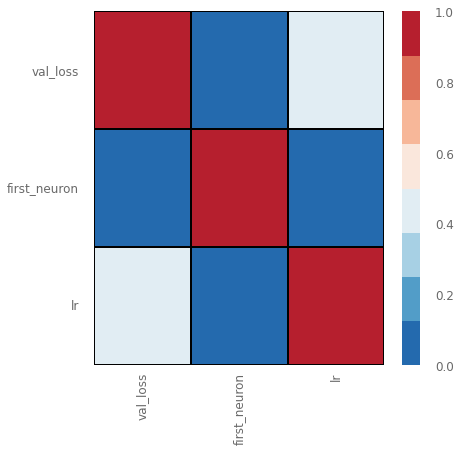

In [14]:
# get a correlation plot for hyperparameters against a metric 
r.plot_corr('val_loss', ['loss', 'val_loss', 'round_epochs', 'epochs', 'batch_size', 'hidden_layers'])
# plt.savefig('curve.png', dpi=1000)

In [15]:
# Get the best model index with highest 'val_loss' 
model_id = r.data['val_loss'].astype('float').argmin() - 0

In [16]:
# Get models index from data 
# model_id = r.data['val_loss'].astype('float').index[26]

In [17]:
model_id

3

* It is possible to retrieve the loss curve of the best model


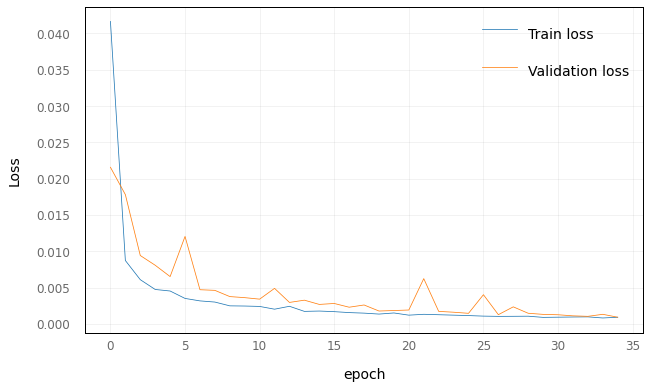

In [18]:
model_history = scan_results.round_history[model_id]

# LOSS CURVE
# Plot train loss and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('Loss curve.png', dpi=1200)
    # plt.show()

plot_loss(model_history)

In [19]:
model_history['loss'][-1]

0.0009015344548970461

In [20]:
model_history['val_loss'][-1]

0.0009048812207765877

In [21]:
def save_best_model(scan_results, model_id, model_name):
    # Clear any previous TensorFlow session.
    tf.keras.backend.clear_session()


    # Load the model parameters from the scanner.
    model = tf.keras.models.model_from_json(scan_results.saved_models[model_id])
    model.set_weights(scan_results.saved_weights[model_id])
    model.summary()
    model.save('./best_model_' + model_name)
    return model


model = save_best_model(scan_results, model_id, 'lstm')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./best_model_lstm/assets


INFO:tensorflow:Assets written to: ./best_model_lstm/assets


In [22]:
def plot_model_summary(model, model_name):
    plot_model(model, to_file='model_summary_' + model_name + '.png', show_shapes=True)


plot_model_summary(model, 'lstm')

In [23]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction

prediction_lstm = prediction(model)

In [24]:
prediction_lstm[:, :] = scaler.inverse_transform(prediction_lstm[:, :])
y_train[:, :] = scaler.inverse_transform(y_train[:, :])
y_test[:, :] = scaler.inverse_transform(y_test[:, :])

In [25]:
y_test

array([[ 84.709999],
       [ 84.57    ],
       [ 84.279999],
       ...,
       [161.529999],
       [160.320007],
       [159.960007]])

In [26]:
prediction_lstm

array([[ 84.59   ],
       [ 85.24627],
       [ 85.16308],
       ...,
       [163.24501],
       [162.67935],
       [161.55786]], dtype=float32)

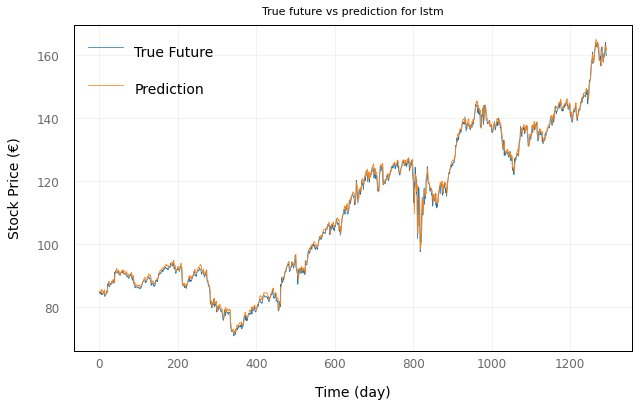

In [27]:
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Stock Price (€)')
    plt.savefig('Prediction_Evaluation_plot_' + model_name + '.png', dpi=1200)
    plt.show()


plot_future(prediction_lstm, 'lstm', y_test)

In [28]:
# Define a function to calculate MAE and RSME
step_ahead=1

# Define a function to calculate MAE and RSME
def evaluate_prediction(predicted, actual, model_name):
    if step_ahead == 1:
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Root Mean Square Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return
    else:
        titles = ["RMSE", "MAE", "R^2"]
        # calculate an RMSE score for each day
        # calculate mse
        rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='raw_values'))
        mae = mean_absolute_error(predicted, actual, multioutput='raw_values')
        r2 = r2_score(predicted, actual, multioutput='raw_values')
        df_scores = pd.DataFrame(list(zip(rmse, mae, r2)), columns=[f'{x}' for x in titles])
        df_scores.index += 1

        colors = plt.rcParams["axes.prop_cycle"]()
        a = 1  # number of rows
        b = 3  # number of columns
        c = 1  # initialize plot counter
        fig = plt.figure(figsize=(15, 6))
        for i in titles:
            plt.subplot(a, b, c)
            plt.title(f'{i}')
            next_colour = next(colors)["color"]
            df_scores[f'{i}'].plot(marker='o', color=next_colour)
            plt.xticks((range(0, df_scores.shape[0] + 1)))
            plt.legend(loc='upper left')
            plt.xlabel('Forecast Range (Day)')
            plt.ylabel(f'{i}')
            c = c + 1

        plt.subplots_adjust(.5)
        fig.suptitle("Evaluation of performances' trend in the multi step forecasted range", fontsize=16, y=1)
        plt.tight_layout()
        # plt.savefig('EvaluationMultiplePrediction_PG.png', dpi=1200)
        plt.show()

        # calculate overall RMSE
        overall_rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='uniform_average'))
        overall_mae = mean_absolute_error(predicted, actual, multioutput='uniform_average')
        overall_r2 = r2_score(predicted, actual, multioutput='uniform_average')
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(overall_r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(overall_mae))
        print('Root Mean Square Error: {:.4f}'.format(overall_rmse))
        print('')
        return


evaluate_prediction(prediction_lstm, y_test, 'Lstm')

lstm performance:
R^2: 99.5424 %
Mean Absolute Error: 1.1124
Root Mean Square Error: 1.6219
Max_error: 12.2365

